# Week 8

## Kinnick Fox
## DSC530

All code before Exercise 9-1 is written by Allen B. Downey



In [5]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [120]:
import numpy as np

import random

import thinkstats2
import thinkplot
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

In [38]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [7]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

In [39]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [25]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [29]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [118]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [123]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

## Exercises

**Exercise 9-1:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [149]:
def SubsetTest(samp, iters):
    print("Testing with {} random samples...".format(samp))
    
    ran_live = thinkstats2.SampleRows(live, samp)
    firsts = ran_live.loc[live.pregordr == 1]
    others = ran_live.loc[live.pregordr != 1]
    all_live_lng = firsts.prglngth.dropna().values, others.prglngth.dropna().values
    all_live_wgt = firsts.totalwgt_lb.dropna().values, others.totalwgt_lb.dropna().values
    
    # permutation test
    data = DiffMeansPermute(all_live_lng)
    print("    Pregnancy length permutation test: {}".format(data.PValue(iters=iters)))
    data = DiffMeansPermute(all_live_wgt)
    print("    Birth weight permutation test: {}".format(data.PValue(iters=iters)))

    # test correlation
    cleaned = ran_live.dropna(subset=['prglngth', 'totalwgt_lb'])
    x = len(ran_live.totalwgt_lb.dropna().values)
    lngth_to_wgt = ran_live.prglngth.values[0:x], ran_live.totalwgt_lb.dropna().values
    data = CorrelationPermute(lngth_to_wgt)
    print("    Correlation permutation test of length of pregnancy and birth weight: {}".format(data.PValue()))

    # chi-squared
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p_value = ht.PValue()
    print("    P-value of pregnancy length test of first babies vs others: {}".format(p_value))

In [150]:
SubsetTest(9000,1000)
SubsetTest(6000,1000)
SubsetTest(3000,1000)
SubsetTest(1000,1000)
SubsetTest(250,1000)

Testing with 9000 random samples...
    Pregnancy length permutation test: 0.68
    Birth weight permutation test: 0.0
    Correlation permutation test of length of pregnancy and birth weight: 0.44
    P-value of pregnancy length test of first babies vs others: 0.0
Testing with 6000 random samples...
    Pregnancy length permutation test: 0.769
    Birth weight permutation test: 0.006
    Correlation permutation test of length of pregnancy and birth weight: 0.001
    P-value of pregnancy length test of first babies vs others: 0.006
Testing with 3000 random samples...
    Pregnancy length permutation test: 0.291
    Birth weight permutation test: 0.449
    Correlation permutation test of length of pregnancy and birth weight: 0.343
    P-value of pregnancy length test of first babies vs others: 0.0
Testing with 1000 random samples...
    Pregnancy length permutation test: 0.119
    Birth weight permutation test: 0.216
    Correlation permutation test of length of pregnancy and birth weig

P-value increases as random samples and certainty decrease.

**Exercise 10-1:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [70]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [71]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [83]:
intercept, slope = thinkstats2.LeastSquares(heights,log_weights)

Make a scatter plot of the data and show the fitted line.

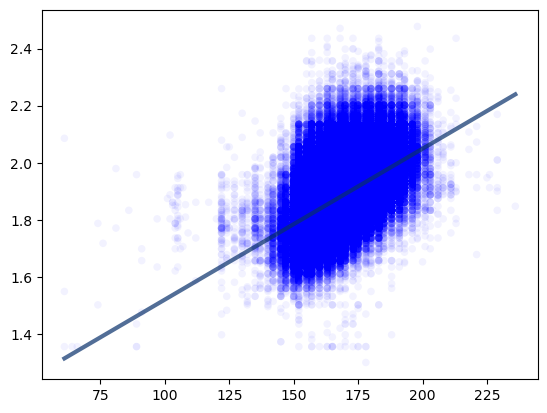

In [85]:
thinkplot.Scatter(heights, log_weights, alpha=0.05)
xs, ys = thinkstats2.FitLine(heights, intercept, slope)
thinkplot.Plot(xs, ys)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

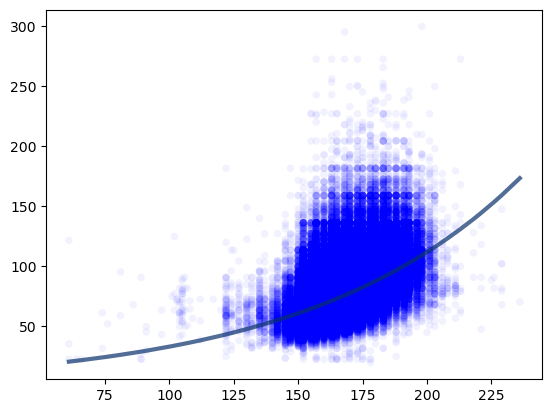

In [92]:
thinkplot.Scatter(heights, weights, alpha=0.05)
thinkplot.Plot(xs, 10**ys)

Plot percentiles of the residuals.

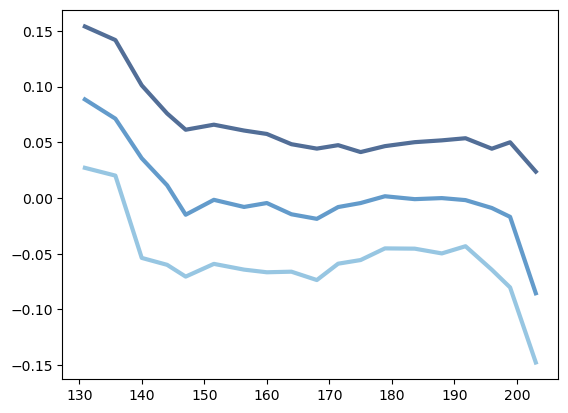

In [94]:
df['res'] = thinkstats2.Residuals(heights, log_weights, intercept, slope)

bins = np.arange(130, 210, 4)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)
means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.res) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)

Compute correlation.

In [98]:
corr = thinkstats2.Corr(heights, log_weights)

Compute coefficient of determination.

In [100]:
residuals = thinkstats2.Residuals(heights, log_weights, intercept, slope)
codet = thinkstats2.CoefDetermination(log_weights, residuals)
codet

0.28273494311893266

Confirm that $R^2 = \rho^2$.

In [101]:
np.isclose(corr**2, codet)

True

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [102]:
std_weights = thinkstats2.Std(log_weights)
std_weights

0.10320725030004867

Compute Std(res), the RMSE of predictions that do use height.

In [104]:
std_residuals = thinkstats2.Std(residuals)
std_residuals

0.08740777080416111

How much does height information reduce RMSE?

In [105]:
1 - std_residuals / std_weights

0.15308497658792974

Use resampling to compute sampling distributions for inter and slope.

In [108]:
dist = []

for _ in range(100):
    samp = thinkstats2.ResampleRows(df)
    est = thinkstats2.LeastSquares(samp.htm3, np.log10(samp.wtkg2))
    dist.append(est)

In [109]:
inters, slopes = zip(*dist)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

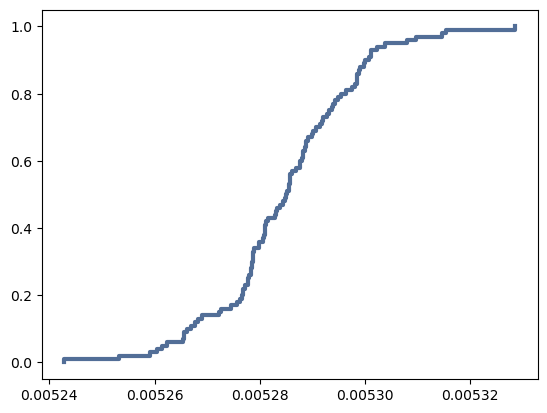

In [110]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [114]:
pval = cdf[0]
pval

0

Compute the 90% confidence interval of slope.

In [ ]:
interval = cdf.Percentile(5), cdf.Percentile(95)
interval

Compute the mean of the sampling distribution.

In [115]:
mean = thinkstats2.Mean(slopes)
mean

0.00528484838356788

Compute the standard deviation of the sampling distribution, which is the standard error.

In [116]:
stderr = thinkstats2.Std(slopes)
stderr

1.3516231209557485e-05

Resample rows without weights, compute mean height, and summarize results.

In [121]:
est_unwghtd = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(est_unwghtd)

mean, SE, CI 168.95858086258818 0.01838781291365951 (168.92212605347723, 168.99041765193314)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [126]:
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.49687097051273 0.016242059775100536 (170.47207653752096, 170.52386618565453)
